# Introduction

**Contents:**

1. Introduces the `GEModelTools`
1. Solves and simulates a simple **Heterogenous Agent Neo-Classical (HANC) model**

In [65]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
from matplotlib import cm # for colormaps
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm # for progress bar
from steady_state import obj_ss_kl

from HANCModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### New model

1. Households: Solve
\begin{align*}
v_{t}(z_{t},a_{t-1})	& =\max_{c_{t}}\frac{c_{t}^{1-\sigma}}{1-\sigma}+\beta\mathbb{E}_{t}\left[v_{t+1}(z_{t+1},a_{t})\right] \\
\text{s.t. }a_{t}+c_{t}	& =(1+r_{t})a_{t-1}+(1-\tau_{t})z_{t}\geq0 \\
\log z_{t+1}	&=\rho_{z}\log z_{t}+\psi_{t+1}\,\,\,,\psi_{t}\sim\mathcal{N}(\mu_{\psi},\sigma_{\psi}),\,\mathbb{E}[z_{t}]=1
\end{align*}
where $r_{t}$ is the real-interest rate and $\tau_{t}$ is a tax rate
2. Government: Set taxes and government bonds follows 
\begin{align*} 
B_{t+1}=(1+r_{t})B_{t}-\int\tau_{t}z_{t}d\boldsymbol{D}_{t} 
\end{align*}

3. Bond market clearing: $B_{t}=\int a_{t}^{\ast}(z_{t},a_{t-1})d\boldsymbol{D}_{t}$

4. Define and find the stationary equilibrium

\begin{align*}
B_{t+1}=(1+r_{t})B_{t}-\int\tau_{t}z_{t}d\boldsymbol{D}_{t} \\
\Rightarrow B_{ss}=(1+r_{ss})B_{ss}-\int\tau_{t}z_{t}d\boldsymbol{D}_{ss} \\
\Leftrightarrow r_{ss}=\frac{1}{B_{ss}}\int\tau_{t}z_{t}d\boldsymbol{D}_{ss}
\end{align*}

\begin{align*}
H_{ss}\left(B_{ss}; \tau_{ss}\right)=
\left[ 
    \begin{matrix}
B_{ss}-\boldsymbol{a}_{ss}^{\ast\prime}\boldsymbol{D}_{ss} \\
r_{ss}-\frac{1}{B_{ss}}\int\tau_{ss}z_{t}d\boldsymbol{D}_{ss} \\
\boldsymbol{D}_{ss}-\Pi_{z}^{\prime}\underline{\boldsymbol{D}}_{ss} \\
\underline{\boldsymbol{D}}_{ss}-\Lambda_{ss}^{\prime}\boldsymbol{D}_{ss}
\end{matrix} 
\right] =\boldsymbol{0}
\end{align*}
With Policy function: $a_{t}^{\ast}=a^{\ast}\left(\left\{ r_{\tau},\tau_{ss}\right\} _{\tau\geq t}\right)$

And Choice transition: $\Lambda_{t}=\Lambda\left(\left\{ r_{\tau},\tau_{ss}\right\} _{\tau\geq t}\right)$

You can also back out tau:
\begin{align*}
\Leftrightarrow \tau_{ss} = \frac{r_{ss}B_{ss}}{\int z_{t}d\boldsymbol{D}_{ss}}
\end{align*}
But because it part of the household problem we cannot use the indirect solution method 

# Setup

In [78]:
model = HANCModelClass(name='A1') # create an instance of the model


In [79]:

ss =model.ss
par  =model.par
ss.r = 0.02
ss.w = 1.

# Preset calibration
ss.taua = 0.1
ss.taul = 0.3
ss.G = 0.3


**Solve the household problem** with `.solve_hh_ss()`:
    
1. Calls `.prepare_hh_ss()`
1. Calls `.solve_backwards_hh()` until convergence

In [80]:
par = model.par
ss = model.ss

In [81]:
model.ss.a.shape

(4, 7, 500)

In [82]:
import time

In [83]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 2.3 secs [220 iterations]


In [84]:
type(model.par)

types.SimpleNamespace

In [19]:
start = time.time()
n = 10
for i in range(n):
    model.solve_hh_ss(do_print=True)
end = time.time()
print(f"Elapsed pr. iteration= {(end-start)/n}")

household problem in ss solved in 0.4 secs [195 iterations]
household problem in ss solved in 0.4 secs [195 iterations]
household problem in ss solved in 0.4 secs [195 iterations]
household problem in ss solved in 0.4 secs [195 iterations]
household problem in ss solved in 0.4 secs [195 iterations]
household problem in ss solved in 0.3 secs [195 iterations]
household problem in ss solved in 0.3 secs [195 iterations]
household problem in ss solved in 0.3 secs [195 iterations]
household problem in ss solved in 0.3 secs [195 iterations]
household problem in ss solved in 0.3 secs [195 iterations]
Elapsed pr. iteration= 0.35352458953857424


In [10]:
#  nb.prange: 0.329770565032959
# range Elapsed pr. iteration= 0.33262689113616944

In [85]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 0.0 secs [180 iterations]


In [86]:
np.sum(model.ss.c*model.ss.D)

0.782434651852273

In [87]:
model.ss.A_hh

2.0298742240517695

In [88]:
np.sum(model.ss.ell*model.ss.D)

1.1511087385572274

In [89]:
model.ss.ELL_hh

1.1511087385572274

In [91]:
model.ss.ell[np.isclose(model.ss.a,0)]

array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

**Aggregate savings:**

In [13]:
np.sum(model.ss.a*model.ss.D)

2.0285394890692183

# Find stationary equilibrium

## Direct approach

In [14]:
model.find_ss(method='root',x0=(3.12,1.01) ,root_method='lm', do_print=True)

### step 1 going strait to optimize.root with guess (K,L) = (3.12,1.01)
   cov_x: array([[8.66926221, 2.78056896],
       [2.78056896, 0.89246256]])
    fjac: array([[-39.96367599,  -0.04385201],
       [ 12.81790243,   0.33963226]])
     fun: array([-4.99600361e-15,  4.44089210e-16])
    ipvt: array([2, 1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 16
     qtf: array([-1.51064688e-07, -1.45884080e-09])
  status: 2
 success: True
       x: array([3.41860807, 1.01213026])
found steady state in 8.7 secs


In [15]:
model.find_ss(method='root',x0=(3.12,1.01) ,root_method='krylov', do_print=True)

### step 1 going strait to optimize.root with guess (K,L) = (3.12,1.01)
     fun: array([-0.0002507, -0.0238612])
 message: 'A solution was found at the specified tolerance.'
     nit: 6
  status: 1
 success: True
       x: array([3.48874509, 1.03466152])
found steady state in 10.5 secs


In [16]:
model.find_ss(method='root',x0=(5,0.9) ,root_method='krylov', do_print=True)

### step 1 going strait to optimize.root with guess (K,L) = (5.00,0.90)
     fun: array([-2.75335310e-14, -6.66133815e-16])
 message: 'A solution was found at the specified tolerance.'
     nit: 6
  status: 1
 success: True
       x: array([5.92765976, 1.03524176])
found steady state in 2.8 secs


In [17]:
model.find_ss(method='root',x0=(5,0.9) ,root_method='df-sane', do_print=True)

### step 1 going strait to optimize.root with guess (K,L) = (5.00,0.90)
     fun: array([6.54777832e-09, 1.85049132e-09])
 message: 'successful convergence'
    nfev: 50
     nit: 46
 success: True
       x: array([5.92765975, 1.03524176])
found steady state in 8.4 secs


##### There are multiple equilibria

In [18]:
model.find_ss(method='root',x0=(5,0.9) ,root_method='hybr', do_print=True)

### step 1 going strait to optimize.root with guess (K,L) = (5.00,0.90)
    fjac: array([[-0.99999389, -0.00349516],
       [ 0.00349516, -0.99999389]])
     fun: array([5.81668047e-12, 5.55111512e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-4.51514384e-09,  1.16951675e-11])
       r: array([  5.06758164, -41.22077997,   1.02646669])
  status: 1
 success: True
       x: array([5.92765976, 1.03524176])
found steady state in 2.0 secs


In [19]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Y              : 1.7474
C              : 0.8546
I              : 0.5928
G              : 0.3000
IB             : 0.0000
Gamma          : 1.0000
K              : 5.9277
L              : 1.0352
B              : -5.7751
taxa           : -0.0002
taxl           : 0.3670
rk             : 0.0884
w              : 1.1815
r              : -0.0116
taua           : 0.1000
taul           : 0.3000
A_hh           : 0.1526
C_hh           : 0.8546
ELL_hh         : 1.1383
U_hh           : -2.0001
L_hh           : 1.0352
clearing_A     : 0.0000
clearing_C     : -0.0000
clearing_L     : 0.0000


In [91]:
5.9277/1.0352

5.726139876352396

In [20]:
model.find_ss(method='root',x0=(3.12,1.01) ,do_print=True)

### step 1 going strait to optimize.root with guess (K,L) = (3.12,1.01)
    fjac: array([[-0.99996676,  0.00815319],
       [-0.00815319, -0.99996676]])
     fun: array([-7.78122011e-12,  2.30038211e-13])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-8.82740731e-09,  1.89124386e-10])
       r: array([  7.30897364, -59.99128578,   1.85704566])
  status: 1
 success: True
       x: array([3.41860807, 1.01213026])
found steady state in 6.7 secs


**Look at the steady state variables:**

In [21]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Y              : 1.4582
C              : 0.8163
I              : 0.3419
G              : 0.3000
IB             : 0.0000
Gamma          : 1.0000
K              : 3.4186
L              : 1.0121
B              : 0.6271
taxa           : 0.0113
taxl           : 0.3062
rk             : 0.1280
w              : 1.0085
r              : 0.0280
taua           : 0.1000
taul           : 0.3000
A_hh           : 4.0458
C_hh           : 0.8162
ELL_hh         : 1.0813
U_hh           : -2.0134
L_hh           : 1.0121
clearing_A     : -0.0000
clearing_C     : -0.0002
clearing_L     : 0.0000


In [22]:
par = model.par
ss = model.ss
for i_fix in range(par.Nfix):
    print(f'Type {i_fix+1}:')
    print(f'zeta   = {par.zeta_grid[i_fix]}, varphi = {par.varphi_grid[i_fix]}')
    c = np.sum(ss.c[i_fix]*ss.D[i_fix])*par.Nfix
    print(f'C*   = {c:.3f}')
    
    a = np.sum(ss.a[i_fix]*ss.D[i_fix])
    print(f'a*   = {a:.3f}')

    ell = np.sum(ss.ell[i_fix]*ss.D[i_fix])*par.Nfix
    print(f'ell* = {ell:.3f}')

    u = np.sum(ss.u[i_fix]*ss.D[i_fix])*par.Nfix
    print(f'u*   = {u:.3f}')


Type 1:
zeta   = 0.9, varphi = 0.9
C*   = 0.787
a*   = 0.975
ell* = 1.155
u*   = -2.076
Type 2:
zeta   = 0.9, varphi = 1.1
C*   = 0.736
a*   = 0.912
ell* = 1.080
u*   = -2.220
Type 3:
zeta   = 1.1, varphi = 0.9
C*   = 0.900
a*   = 1.115
ell* = 1.080
u*   = -1.816
Type 4:
zeta   = 1.1, varphi = 1.1
C*   = 0.842
a*   = 1.043
ell* = 1.010
u*   = -1.942


In [ ]:
## Solve using captial-labor ratio

In [51]:
model = HANCModelClass(name='A1') # create an instance of the model
ss =model.ss
par  =model.par
ss.r = 0.02
ss.w = 1.

# Preset calibration
ss.taua = 0.1
ss.taul = 0.3
ss.G = 0.3


In [52]:
#model.find_ss(method='kl',solveclearing='L',do_print=True)

In [53]:
model.find_ss(method='kl',solveclearing='A',roption='positive',do_print=True)

  0: KL =   3.61242095 -> A_clearing =  -2.60351206
  1: KL =   3.45868506 -> A_clearing =  -1.02052207
  2: KL =   3.36163718 -> A_clearing =   0.23222839
  3: KL =   3.37962742 -> A_clearing =  -0.02064978
  4: KL =   3.37815835 -> A_clearing =  -0.00039541
  5: KL =   3.37812972 -> A_clearing =   0.00000001
  6: KL =   3.37812974 -> A_clearing =  -0.00000029

KL =   3.37812972 [A_clearing =   0.00000001]

found steady state in 10.7 secs


In [54]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Y              : 1.4581
C              : 0.8163
I              : 0.3419
G              : 0.3000
IB             : 0.0000
Gamma          : 1.0000
K              : 3.4188
L              : 1.0120
KL             : 3.3781
B              : 0.6266
taxa           : 0.0113
taxl           : 0.3062
rk             : 0.1280
w              : 1.0086
r              : 0.0280
taua           : 0.1000
taul           : 0.3000
A_hh           : 4.0454
C_hh           : 0.8163
ELL_hh         : 1.0812
U_hh           : -2.0131
L_hh           : 1.0120
clearing_A     : -0.0000
clearing_C     : -0.0000
clearing_L     : 0.0000


In [48]:
model.find_ss(method='kl',solveclearing='A',roption='negative',do_print=True)

guess ss.KL = 5.0442
implied ss.r = -0.0034
implied ss.w = 1.1375
household problem in ss solved in 0.3 secs [113 iterations]
household problem in ss simulated in 0.0 secs [66 iterations]
implied ss.A_hh = 0.3075
implied ss.B = -17.1678
guess ss.KL = 28.8239
implied ss.r = -0.0715
implied ss.w = 1.9188
household problem in ss solved in 0.1 secs [40 iterations]
household problem in ss simulated in 0.0 secs [2 iterations]
implied ss.A_hh = 0.0000
implied ss.B = -2.8848
  0: KL =  13.40832385 -> A_clearing = -10.10615830
  1: KL =   9.61661005 -> A_clearing =  -6.66376686
  2: KL =   7.33039802 -> A_clearing =  -4.03479173
  3: KL =   6.18729201 -> A_clearing =  -1.79211925
  4: KL =   5.61573900 -> A_clearing =   0.65873122
  5: KL =   5.76935906 -> A_clearing =  -0.22514224
  6: KL =   5.73022861 -> A_clearing =  -0.02334880
  7: KL =   5.72585596 -> A_clearing =   0.00007557
  8: KL =   5.72587007 -> A_clearing =  -0.00000030
  9: KL =   5.72587001 -> A_clearing =  -0.00000000
 10: KL 

In [49]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Y              : 1.7474
C              : 0.8546
I              : 0.5928
G              : 0.3000
IB             : 0.0000
Gamma          : 1.0000
K              : 5.9277
L              : 1.0352
KL             : 5.7259
B              : -5.7751
taxa           : -0.0002
taxl           : 0.3670
rk             : 0.0884
w              : 1.1815
r              : -0.0116
taua           : 0.1000
taul           : 0.3000
A_hh           : 0.1526
C_hh           : 0.8546
ELL_hh         : 1.1383
U_hh           : -2.0001
L_hh           : 1.0352
clearing_A     : 0.0000
clearing_C     : -0.0000
clearing_L     : 0.0000


In [109]:
model_calib = model.copy()
model_calib.ss.taua = 0.2
model_calib.ss.taul = 0.1


In [50]:
model_calib.find_ss(method='kl',solveclearing='A',roption='negative',do_print=True)

guess ss.KL = 5.0442
implied ss.r = -0.0034
implied ss.w = 1.1375
household problem in ss solved in 0.3 secs [111 iterations]
household problem in ss simulated in 0.0 secs [67 iterations]
implied ss.A_hh = 0.3759
implied ss.B = 56.7629
guess ss.KL = 28.8239
implied ss.r = -0.0715
implied ss.w = 1.9188
household problem in ss solved in 0.1 secs [40 iterations]
household problem in ss simulated in 0.0 secs [2 iterations]
implied ss.A_hh = 0.0000
implied ss.B = 2.0265
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\hms467\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\hms467\AppData\Local\Temp\ipykernel_25140\1562268194.py", line 1, in <cell line: 1>
    model_calib.find_ss(method='kl',solveclearing='A',roption='negative',do_print=True)
  File "c:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\A1_hanc\steady_state.py", line 135, in find_ss
    find_ss_kl(model,solveclearing,roption,lower,upper_mult,step, kl_bounds,do_print=do_print)
  File "c:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\A1_hanc\steady_state.py", line 212, in find_ss_kl
    assert fa*fb<=0, f'\nSolution not found for kl bounds = {kl_bounds[0]:10.3f}, {kl_bounds[1]:10.3f}\nClearings:                       = {fa:10.3f}, {fb:10.3f}'
AssertionEr

In [111]:
from steady_state import obj_ss_kl

In [117]:
klguess0 = (model_calib.par.delta/(model_calib.par.alpha*model_calib.ss.Gamma))**(1/(model_calib.par.alpha-1))
#klguess0*6
obj_ss_kl(klguess0*1.05,model_calib,'A',do_print=True)

guess ss.K = 4.8631
implied ss.r = -0.0034
implied ss.w = 1.1375
household problem in ss solved in 0.3 secs [111 iterations]
household problem in ss simulated in 0.0 secs [67 iterations]
implied ss.A_hh = 0.3759
implied ss.B = 56.7629


-61.25014872484752

In [120]:
obj_ss_kl(klguess0*50,model_calib,'A',do_print=True)

guess ss.K = 293.2210
implied ss.r = -0.0935
implied ss.w = 3.6247
household problem in ss solved in 0.1 secs [36 iterations]
household problem in ss simulated in 0.0 secs [2 iterations]
implied ss.A_hh = 0.0000
implied ss.B = 0.6723


-157.8055427165031

In [150]:
obj = lambda x : -obj_ss_kl(x,model_calib,'A',do_print=False)

In [129]:
obj(klguess0*50)

-157.8055427165031

In [136]:
klguess0*1.05,klguess0*100

(5.044185989506746, 480.3986656673091)

In [153]:
res = optimize.minimize_scalar(obj,bounds=(klguess0*1.05,klguess0*300),method='Bounded')
res

     fun: 13.135765400192643
 message: 'Solution found.'
    nfev: 28
  status: 0
 success: True
       x: 8.864000323688852

In [155]:
model_calib.find_ss(method='kl',roption='negative',kl_bounds=(klguess0*1.05,8.864001538681578), do_print=True)

guess ss.KL = 5.0442
implied ss.r = -0.0034
implied ss.w = 1.1375
household problem in ss solved in 0.2 secs [111 iterations]
household problem in ss simulated in 0.0 secs [67 iterations]
implied ss.A_hh = 0.3759
implied ss.B = 56.7629
guess ss.KL = 8.8640
implied ss.r = -0.0349
implied ss.w = 1.3471
household problem in ss solved in 0.1 secs [67 iterations]
household problem in ss simulated in 0.0 secs [42 iterations]
implied ss.A_hh = 0.0250
implied ss.B = 5.0918
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\hms467\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\hms467\AppData\Local\Temp\ipykernel_22840\3576049577.py", line 1, in <cell line: 1>
    model_calib.find_ss(method='kl',roption='negative',kl_bounds=(klguess0*1.05,8.864001538681578), do_print=True)
  File "c:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\A1_hanc\steady_state.py", line 135, in find_ss
    find_ss_kl(model,solveclearing,roption,lower,upper_mult,step, kl_bounds,do_print=do_print)
  File "c:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\A1_hanc\steady_state.py", line 213, in find_ss_kl
    assert fa*fb<=0, f'\nSolution not found for kl bounds = {kl_bounds[0]:10.3f}, {kl_bounds[1]:10.3f}\nClearings:                       = {fa:10.3

In [143]:
obj(8.86400031320901)

172.54833264889828

In [144]:
model_calib.ss.KL

8.86400031320901

In [146]:
for varname in model_calib.varlist:
    print(f'{varname:15s}: {model_calib.ss.__dict__[varname]:.4f}')

Y              : 1.7518
C              : 0.6449
I              : 0.8069
G              : 0.3000
IB             : -0.0000
Gamma          : 1.0000
K              : 8.0690
L              : 0.9103
KL             : 8.8640
B              : 5.0918
taxa           : -0.0002
taxl           : 0.1226
rk             : 0.0651
w              : 1.3471
r              : -0.0349
taua           : 0.2000
taul           : 0.1000
A_hh           : 0.0250
C_hh           : 1.1029
ELL_hh         : 1.0035
U_hh           : -1.5525
L_hh           : 0.9103
clearing_A     : -13.1358
clearing_C     : 0.4580
clearing_L     : 0.0000


In [135]:
model_calib.ss.KL

0.0

### Multiple equilibria? 

In [8]:

def clearing_across_kl(model,start,end,N,solveclearing='A',varlist =[ 'Y', 'C_hh','U_hh','A_hh','ELL_hh','I','K','L','B','taxa','taxl','r','w','clearing_A','clearing_C','clearing_L']):
    kl_list = np.linspace(start,end,N)
    
    out_dict = {var :np.empty(N) for var in varlist}

    model_calib = model.copy()
    for i in range(N):
        clearingi = obj_ss_kl(kl_list[i],model_calib,solveclearing)
        for key, val in out_dict.items():
            val[i] = getattr(model_calib.ss,key)
                
    return kl_list, out_dict


In [47]:
kl_list, clearing_list = clearing_across_kl(model,0.01,30,100)

In [9]:
def plot_clearing_across_kl(kl_list,out_dict,plotvar,solveclearing='A'):
    fig = plt.figure(figsize=(12,4),dpi=100)
    ax = fig.add_subplot(1,1,1)

    ax.plot(kl_list,out_dict[plotvar])
    ax.set_xlabel('$\\frac{K}{L}$-ratio')
    ax.set_ylabel(f'{plotvar}')


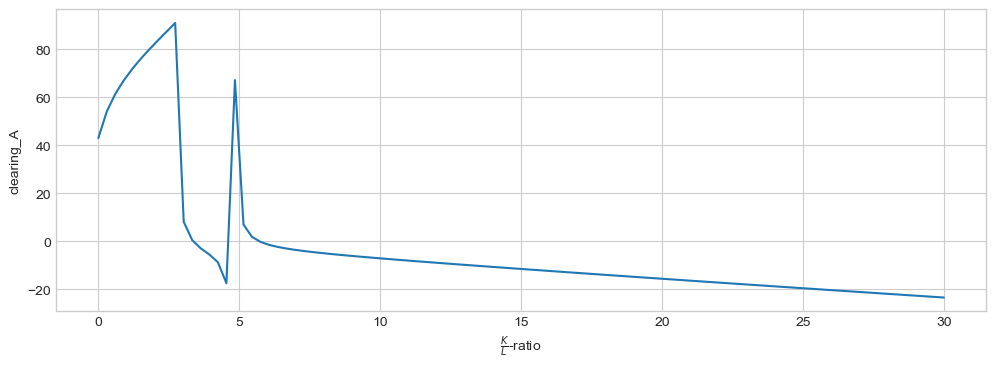

In [44]:
plot_clearing_across_kl(kl_list,clearing_list,'clearing_A')

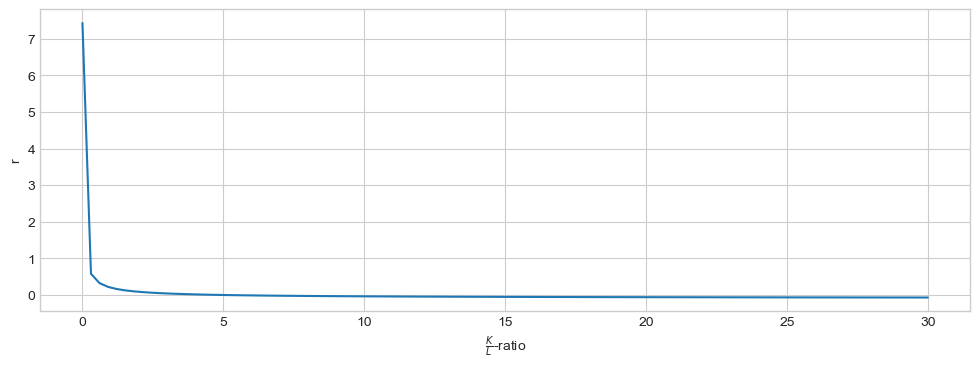

In [61]:
plot_clearing_across_kl(kl_list,clearing_list,'r')

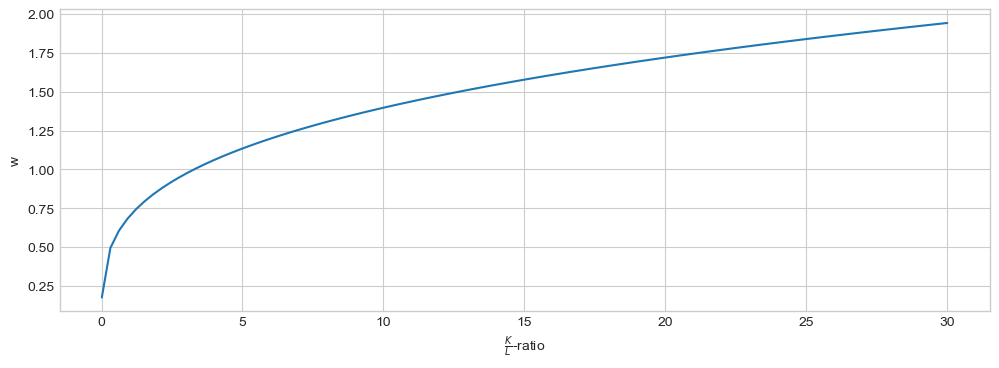

In [54]:
plot_clearing_across_kl(kl_list,clearing_list,'w')

In [15]:
kl_list_zoom, clearing_list_zoom = clearing_across_kl(model,0.1,6,100)

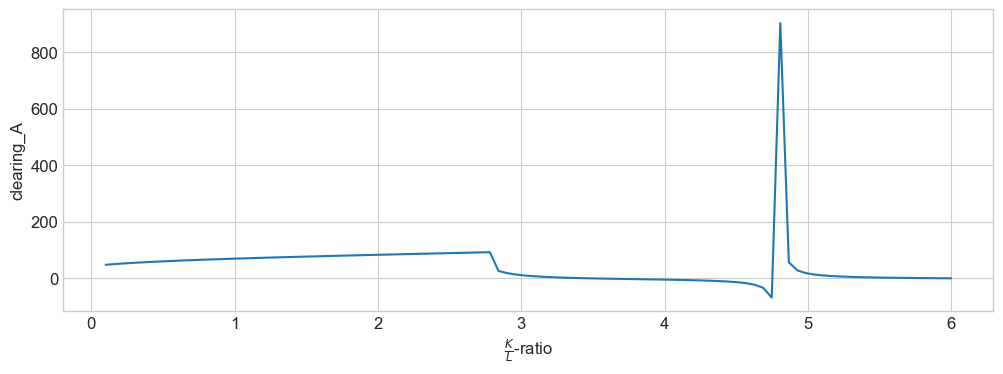

In [16]:

plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'clearing_A')

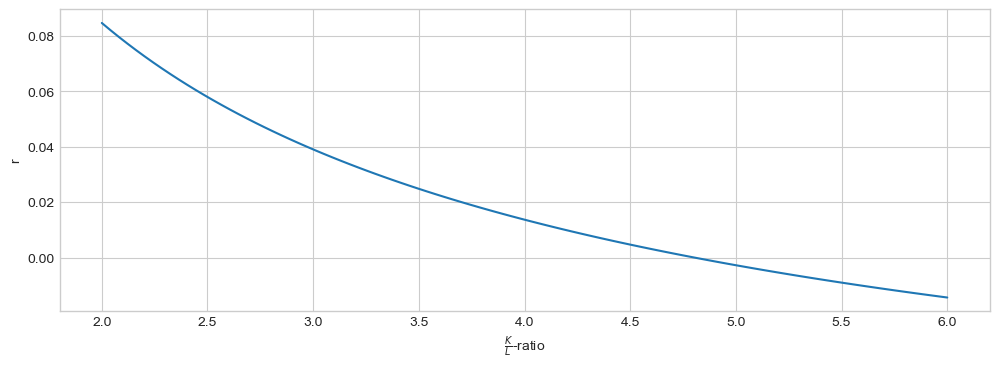

In [74]:
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'r')

In [73]:
np.sum(np.isclose(clearing_list_zoom['clearing_A'],0))

0

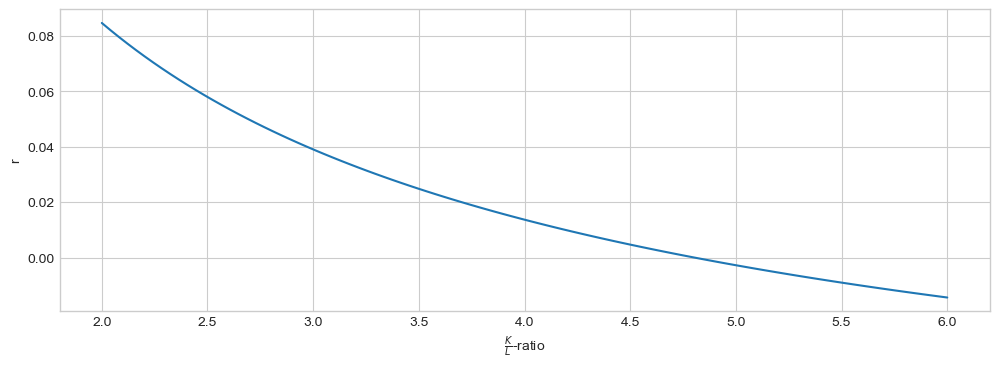

In [65]:
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'r')

In [77]:
# Guess that makes r=0
par = model.par
ss  = model.ss
klguess0 = (par.delta/(par.alpha*ss.Gamma))**(1/(par.alpha-1))

try:
    clearing_A = obj_ss_kl(klguess0,model,'A')
except:
    print(f'Not possible to solve for K/L = {klguess0:2.f}')


Tried r close to zero, returning the previous clearing values


c:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\A1_hanc\steady_state.py:290: RuntimeWarning: invalid value encountered in double_scalars
  ss.Y = ss.Gamma*ss.K**par.alpha*ss.L**(1-par.alpha)


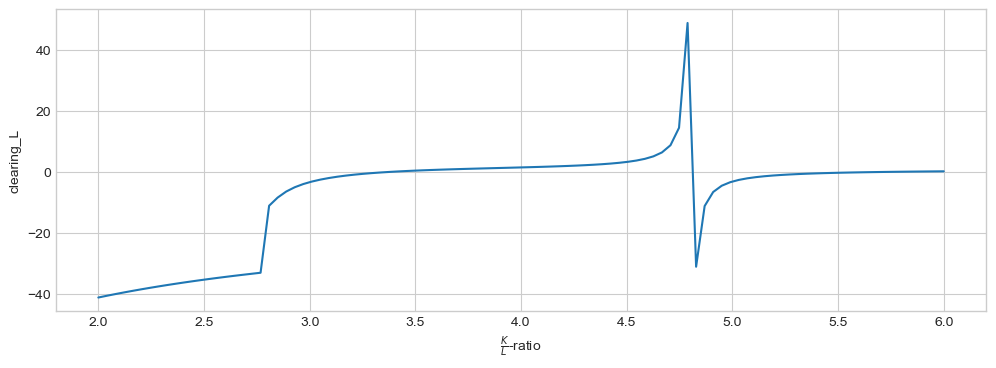

In [78]:
kl_list_zoom, clearing_list_zoom = clearing_across_kl(model,2.,6,100,solveclearing='L')
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'clearing_L')

In [10]:
model_calib = model.copy()
model_calib.ss.taua=0.2
model_calib.ss.taul=0.1

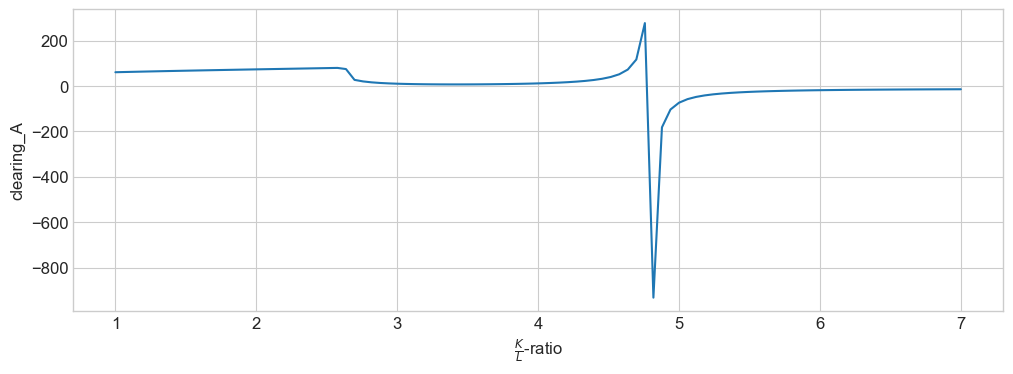

In [11]:
kl_list_zoom, clearing_list_zoom = clearing_across_kl(model_calib,1.,7.,100)
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'clearing_A')

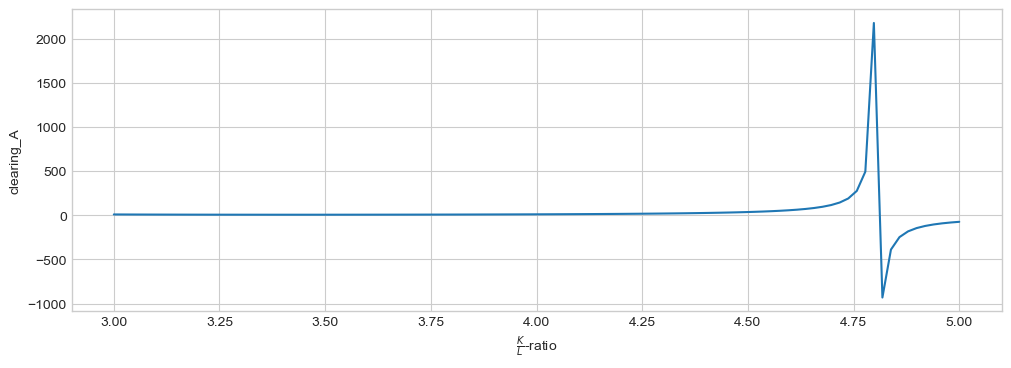

In [87]:
kl_list_zoom, clearing_list_zoom = clearing_across_kl(model_calib,3.,5.,100)
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'clearing_A')

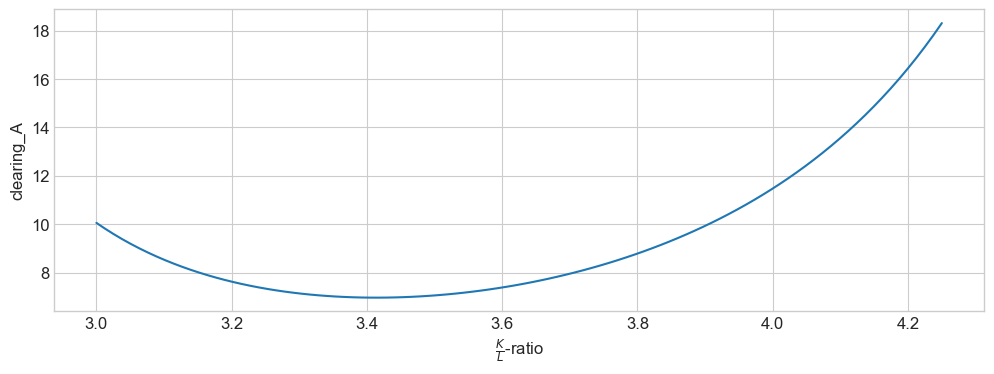

In [12]:
kl_list_zoom, clearing_list_zoom = clearing_across_kl(model_calib,3.,4.25,100)
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'clearing_A')

In [14]:
np.min(clearing_list_zoom['clearing_A'])

6.962664416783571

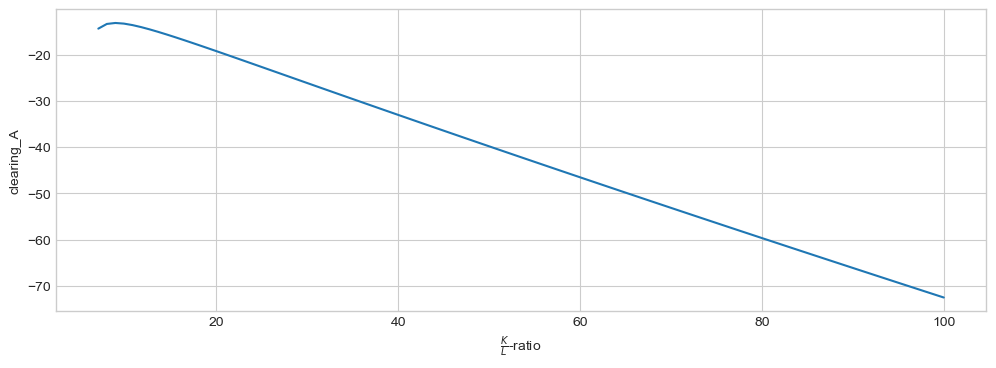

In [89]:
kl_list_zoom, clearing_list_zoom = clearing_across_kl(model_calib,7.,100,100)
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'clearing_A')

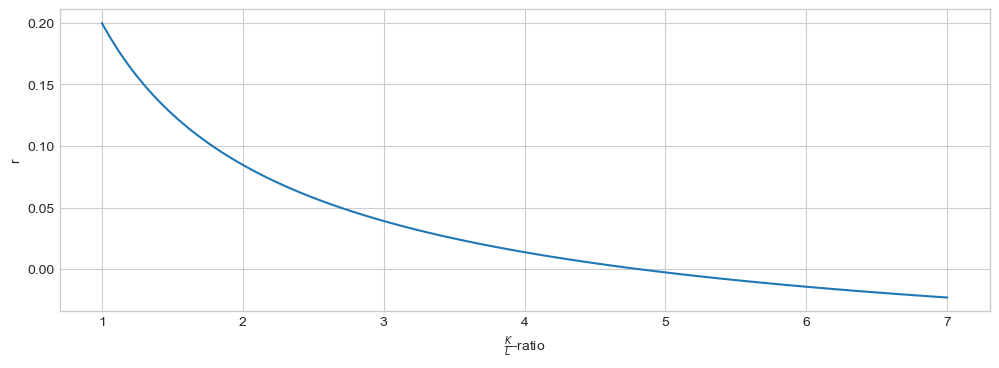

In [86]:
plot_clearing_across_kl(kl_list_zoom,clearing_list_zoom,'r')

## Looking at the stationary equilibrium

### Policy functions

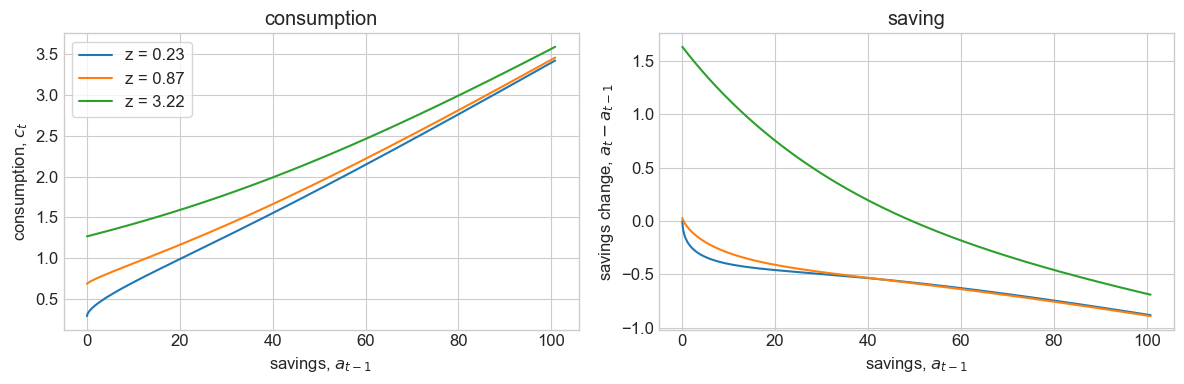

In [23]:
fig = plt.figure(figsize=(12,4),dpi=100)
par = model.par
I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,2,1)
ax.set_title(f'consumption')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'z = {z:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(1,2,2)
ax.set_title(f'saving')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],ss.a[0,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

fig.tight_layout()

In [24]:
np.sum(ss.c[i_fix,:,I]*ss.D[i_fix,:,I]*4/np.mean(I), axis=1).shape

(500,)

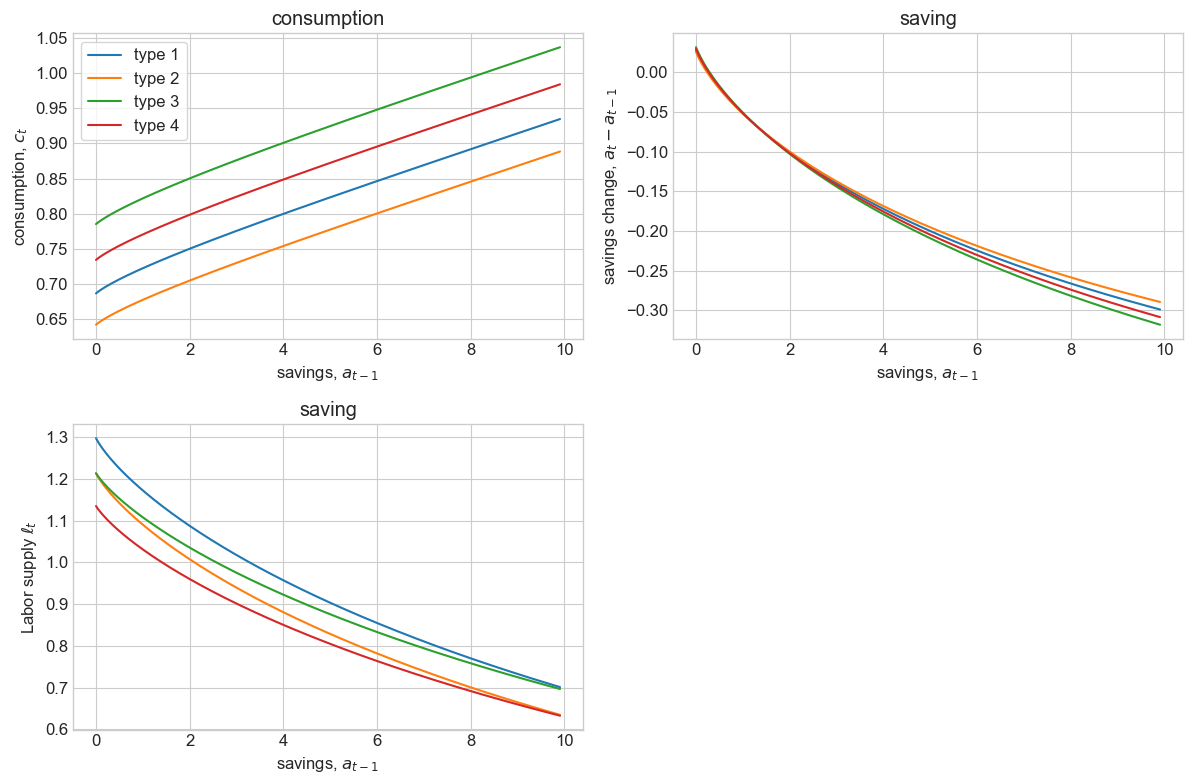

In [25]:
fig = plt.figure(figsize=(12,8),dpi=100)
par = model.par
I = par.a_grid < 10

# a. consumption
ax = fig.add_subplot(2,2,1)
ax.set_title(f'consumption')

for i_fix in range(par.Nfix):
    ax.plot(par.a_grid[I],ss.c[i_fix,3,I],label=f'type {i_fix+1}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(2,2,2)
ax.set_title(f'saving')

for i_fix in range(par.Nfix):
    ax.plot(par.a_grid[I],ss.a[i_fix,3,I]-par.a_grid[I],label=f'type {i_fix+1}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')


ax = fig.add_subplot(2,2,3)
ax.set_title(f'saving')

for i_fix in range(par.Nfix):
    ax.plot(par.a_grid[I],ss.ell[i_fix,3,I],label=f'type {i_fix+1}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('Labor supply $\ell_{t}$')




fig.tight_layout()

### Distributions

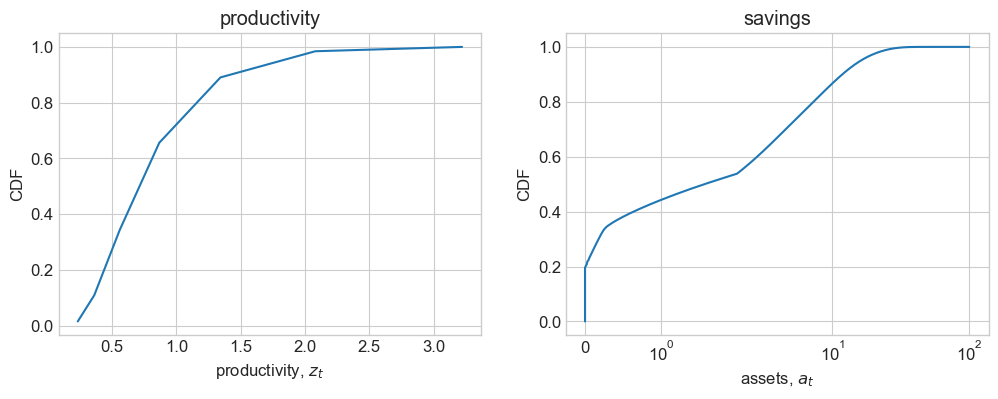

In [26]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
ax.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

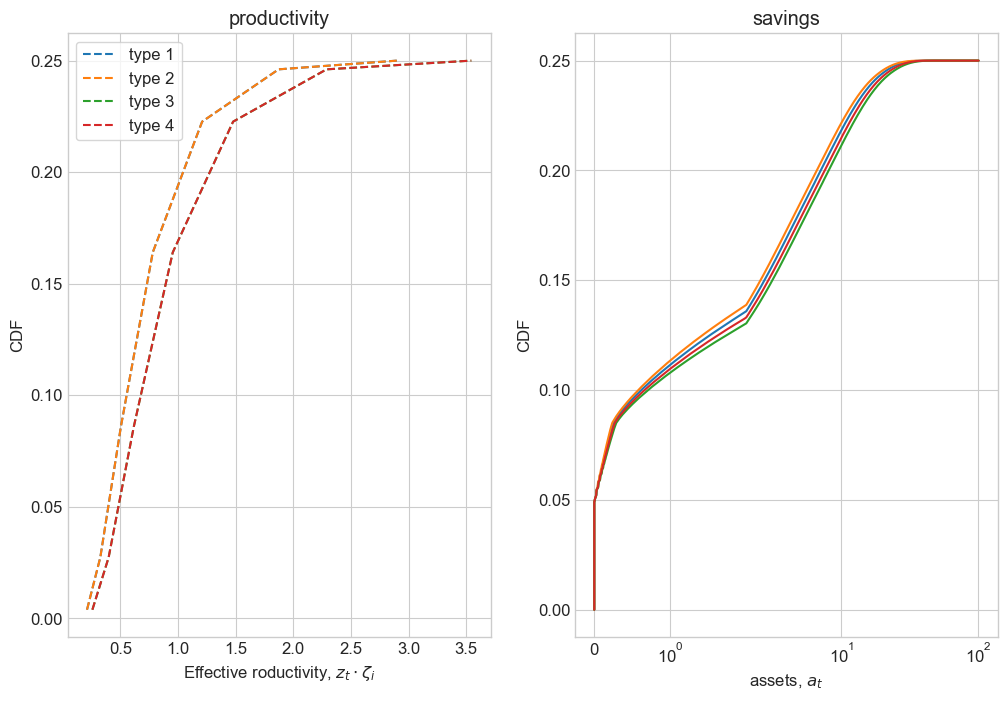

In [27]:
fig = plt.figure(figsize=(12,8),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
for i_fix in range(par.Nfix):
    ax.plot(par.z_grid*par.zeta_grid[i_fix],np.cumsum(np.sum(ss.D[i_fix],axis=(1))),label=f'type {i_fix+1}',linestyle='--')

ax.legend(frameon=True)

ax.set_xlabel('Effective roductivity, $z_{t}\cdot\zeta_{i}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_fix in range(par.Nfix):
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D[i_fix],axis=0)),0,0.0),label=f'type {i_fix+1}')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog');

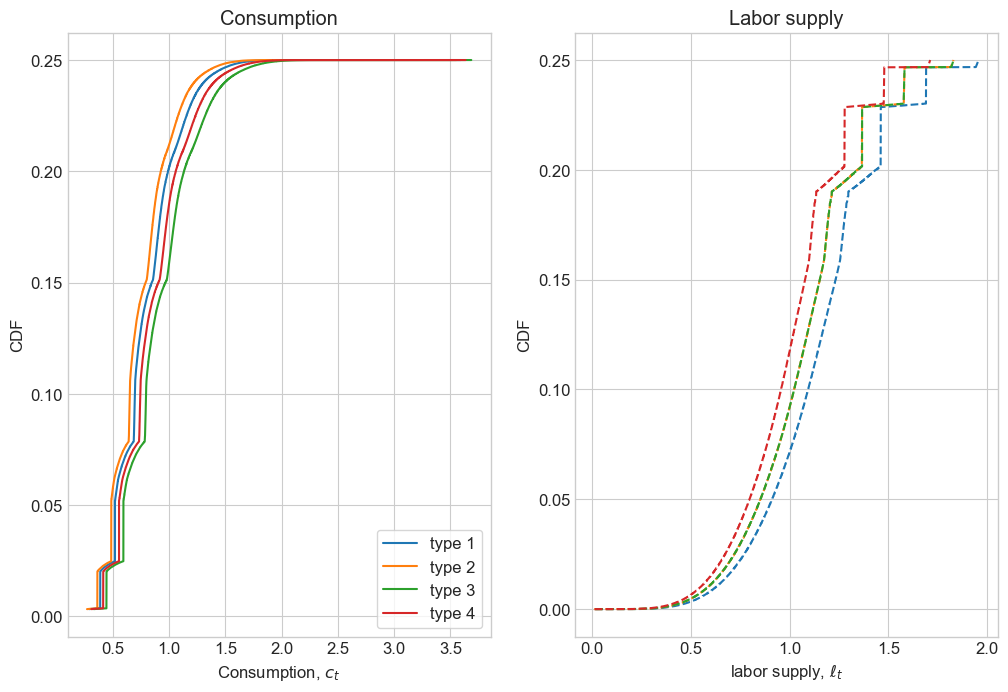

In [28]:
fig = plt.figure(figsize=(12,8),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('Consumption')
for i_fix in range(par.Nfix):

    c_vec = ss.c[i_fix].flatten()
    I = np.argsort(c_vec)
    d_vec = ss.D[i_fix].flatten()

    ax.plot(c_vec[I],np.cumsum(d_vec[I] ) ,label=f'type {i_fix+1}')

ax.legend(frameon=True)

ax.set_xlabel('Consumption, $c_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('Labor supply')
for i_fix in range(par.Nfix):
    ell_vec = ss.ell[i_fix].flatten()
    I = np.argsort(ell_vec)
    d_vec = ss.D[i_fix].flatten()

    ax.plot(ell_vec[I],np.cumsum(d_vec[I] ) ,label=f'type {i_fix+1}',linestyle='--')


ax.set_xlabel('labor supply, $\ell_{t}$')
ax.set_ylabel('CDF');

**Asset moments:**

In [29]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a:  4.046
p25  a:  0.089
p50  a:  1.574
p95  a: 16.163
p99  a: 25.319
std. a:  5.724


### Illustrate how changes in the tax rates affect the stationary equilibrium

In [20]:
model = HANCModelClass(name='A1') # create an instance of the model

ss =model.ss
par  =model.par
ss.r = 0.02
ss.w = 1.

# Preset calibration
ss.taua = 0.1
ss.taul = 0.3
ss.G = 0.3


In [19]:

def make_model_dict(model,gridsize,start,end,roption='positive',method='kl',
                    varlist =[ 'Y', 'C_hh','U_hh','A_hh','ELL_hh','I','K','L','B','taxa','taxl','r','w']):
    
    tau_list = np.linspace(start,end,gridsize)


    # Making a full list storing all the models used too much memor
    #model_grid = np.empty( (gridsize,gridsize),dtype= object)

    
    # Instead store output
    model_dict = {var :np.empty( (gridsize,gridsize)) for var in varlist}

    model_solved= np.full((gridsize,gridsize), True)


    for ia, taua in enumerate(tqdm(tau_list)):
        for il, taul in enumerate(tau_list):
            
            
            # reset tax rates:  
            ss =model.ss
            ss.taua = taua 
            ss.taul = taul

            # Solve model 
            try:
                model.find_ss(method=method,roption=roption,do_print=False)
                # Store welfare
                
                for key, val in model_dict.items():
                    val[ia,il] = getattr(ss,key)
                

            except:
                # Note that model is not solved
                model_solved[ia,il] = False

                for key, val in model_dict.items():
                    val[ia,il] = np.nan



    # store tau lists for plotting 

    model_dict['taua_list'] = tau_list
    model_dict['taul_list'] = tau_list
    model_dict['model_solved'] = model_solved

    return model_dict

In [8]:
model_dict_pos = make_model_dict(model,20,0.,0.9,roption='positive')

100%|██████████| 20/20 [27:31<00:00, 82.56s/it]


In [9]:
model_dict_pos['U_hh']

array([[        nan,         nan,         nan,         nan,         nan,
                nan, -2.00142237, -2.01989573, -2.04024263, -2.06291912,
        -2.08841175, -2.11740313, -2.15083115, -2.19004766, -2.23716125,
        -2.29552122, -2.37095973, -2.4744239 , -2.6289238 , -2.89184523],
       [        nan,         nan,         nan,         nan,         nan,
                nan, -2.00384802, -2.0228257 , -2.04355347, -2.06654078,
        -2.09231317, -2.12157118, -2.15526464, -2.19475762, -2.24217309,
        -2.30087863, -2.37673645, -2.48074416, -2.6360807 , -2.90057419],
       [        nan,         nan,         nan,         nan,         nan,
                nan, -2.00661125, -2.02613592, -2.04726547, -2.07058995,
        -2.09666679, -2.12621503, -2.16019773, -2.20001122, -2.24775873,
        -2.30684463, -2.38316328, -2.48781583, -2.64401914, -2.90878739],
       [        nan,         nan,         nan,         nan,         nan,
                nan, -2.00979237, -2.02989614, -

In [10]:
model_dict_neg = make_model_dict(model,20,0.,0.9,roption='negative')

100%|██████████| 20/20 [09:16<00:00, 27.84s/it]


In [21]:
model_dict_zoom_pos = make_model_dict(model,15,0.24,0.4,roption='positive')

100%|██████████| 15/15 [15:41<00:00, 62.77s/it]


In [22]:
model_dict_zoom_neg = make_model_dict(model,15,0.24,0.4,roption='negative')

100%|██████████| 15/15 [1:11:59<00:00, 288.00s/it]  


In [13]:
folder_path = r'C:\Users\hms467\OneDrive - University of Copenhagen\Documents\Uni\11. semester\AMHA\AdvMacroHet\Assignments\Handin\A1_hanc\saved'

In [15]:
np.save(folder_path + r'\model_dict_pos.npy',model_dict_pos)
np.save(folder_path + r'\model_dict_neg.npy',model_dict_neg)
np.save(folder_path + r'\model_dict_zoom_pos.npy',model_dict_zoom_pos)
np.save(folder_path + r'\model_dict_zoom_neg.npy',model_dict_zoom_neg)

In [3]:
model_dict = np.load(folder_path + r'\model_dict.npy',allow_pickle=True).item()
model_dict_zoom = np.load(folder_path + r'\model_dict_zoom.npy',allow_pickle=True).item()
#gridsize = 11
#tau_list = np.linspace(0.01,0.8,gridsize)


In [35]:
#model_dict['taua_list'] = np.linspace(0.01,0.8,11)
#model_dict['taul_list'] = np.linspace(0.01,0.8,11)

In [23]:
%matplotlib widget

In [57]:
opt = np.nanargmax(model_dict['U_hh'])

In [58]:
model_dict['U_hh'].flatten()[opt]

-1.5818059318400874

In [59]:
taua_list = model_dict['taua_list']
taul_list = model_dict['taul_list']

taua_grid, taul_grid = np.meshgrid(taua_list,taul_list,indexing='ij')

taua_grid.flatten()[opt]

0.0

In [60]:
taul_grid.flatten()[opt]

0.0

In [61]:
opt = np.nanargmax(model_dict_zoom['U_hh'])
print(model_dict_zoom['U_hh'].flatten()[opt])
taua_list = model_dict_zoom['taua_list']
taul_list = model_dict_zoom['taul_list']

taua_grid, taul_grid = np.meshgrid(taua_list,taul_list,indexing='ij')

print(taua_grid.flatten()[opt])
print(taul_grid.flatten()[opt])

-1.1848433312170714
0.015384615384615384
0.007692307692307692


In [25]:
from matplotlib import cm # for colormaps
from mpl_toolkits.mplot3d import Axes3D


def plot_over_taugrid(model_dict,zvar,zname=''):
    taua_list = model_dict['taua_list']
    taul_list = model_dict['taul_list']

    taua_grid, taul_grid = np.meshgrid(taua_list,taul_list,indexing='ij')

    zgrid = model_dict[zvar]
    
    
    # a. actual plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection='3d')
    
    ax.plot_surface(taua_grid,taul_grid,zgrid,cmap=cm.jet)
    
    ax.scatter(taua_grid,taul_grid,zgrid,cmap=cm.jet)
    
    # b. add labels
    ax.set_xlabel('$\\tau^{a}$') 
    ax.set_ylabel('$\\tau^{\ell}$')
    ax.set_zlabel(zname)

    # c. invert xaxis to bring Origin in center front
    ax.invert_xaxis()
    fig.tight_layout()
    


#plot_over_taugrid(model_dict,'U_hh',zname='Average utility')

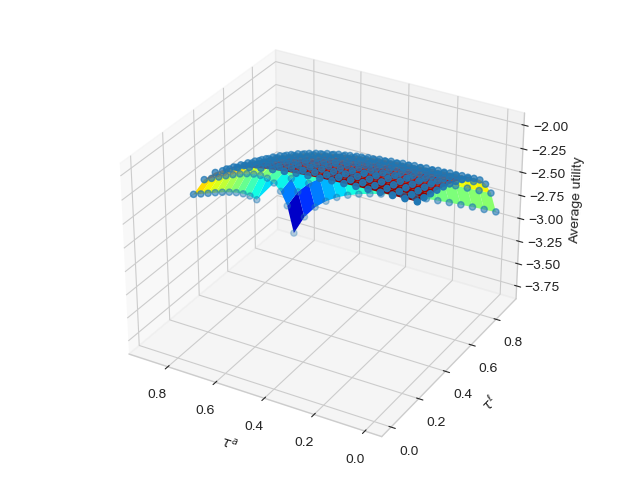

In [19]:
plot_over_taugrid(model_dict_pos,'U_hh',zname='Average utility')

In [27]:
plot_over_taugrid(model_dict_neg,'U_hh',zname='Average utility')

NameError: name 'model_dict_neg' is not defined

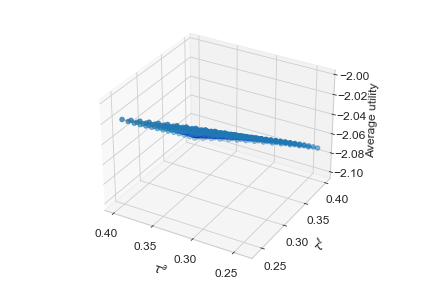

In [26]:
plot_over_taugrid(model_dict_zoom_pos,'U_hh',zname='Average utility')

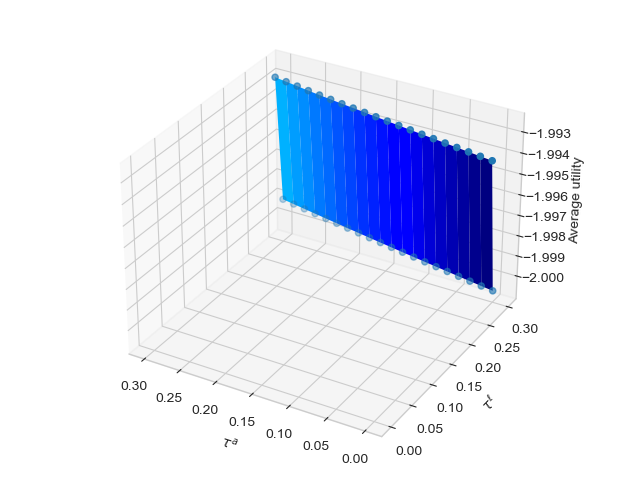

In [22]:
plot_over_taugrid(model_dict_zoom_neg,'U_hh',zname='Average utility')

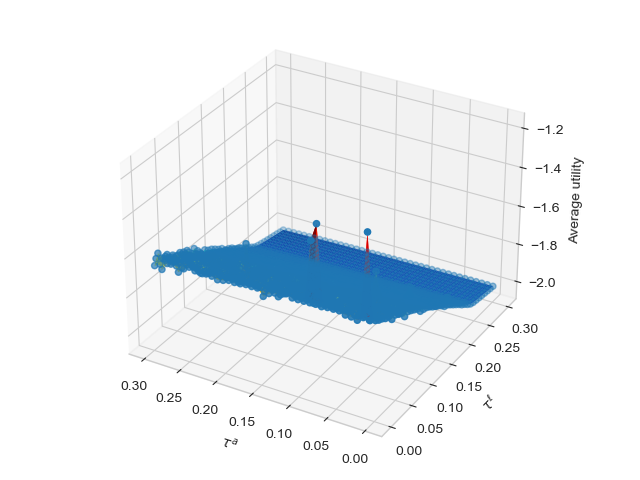

In [6]:
plot_over_taugrid(model_dict_zoom,'U_hh',zname='Average utility')

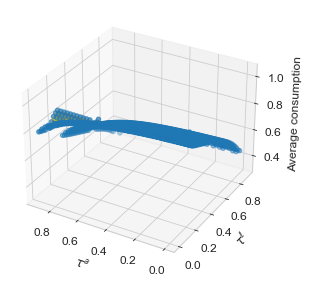

In [38]:

plot_over_taugrid(model_dict,'C_hh',zname='Average consumption')

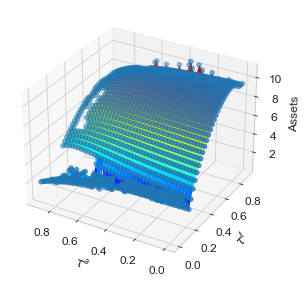

In [39]:
plot_over_taugrid(model_dict,'A_hh',zname='Assets')

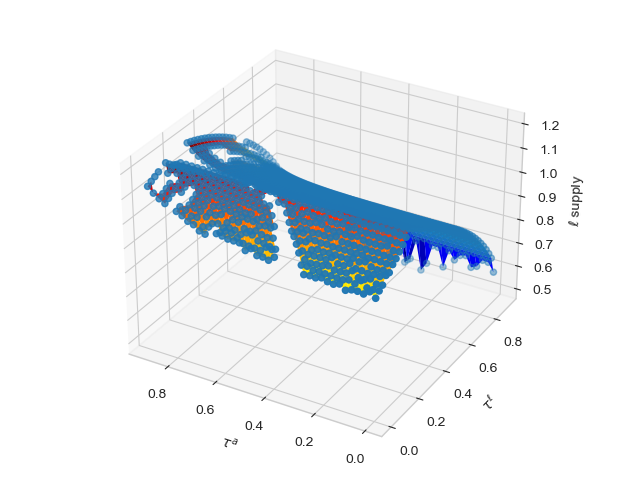

In [63]:
plot_over_taugrid(model_dict,'ELL_hh',zname='$\ell$ supply')

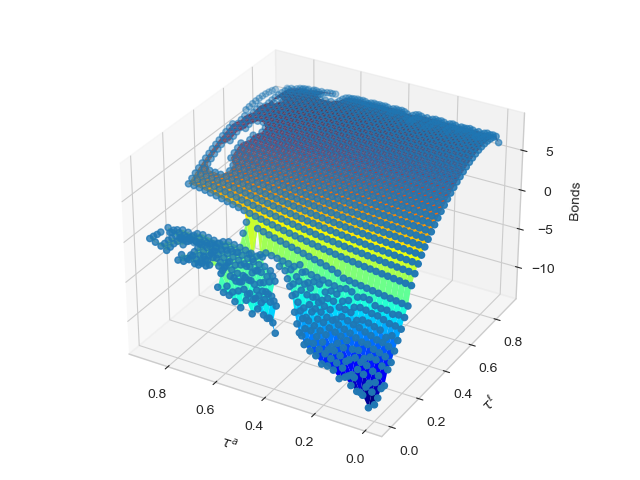

In [64]:
plot_over_taugrid(model_dict,'B',zname='Bonds')

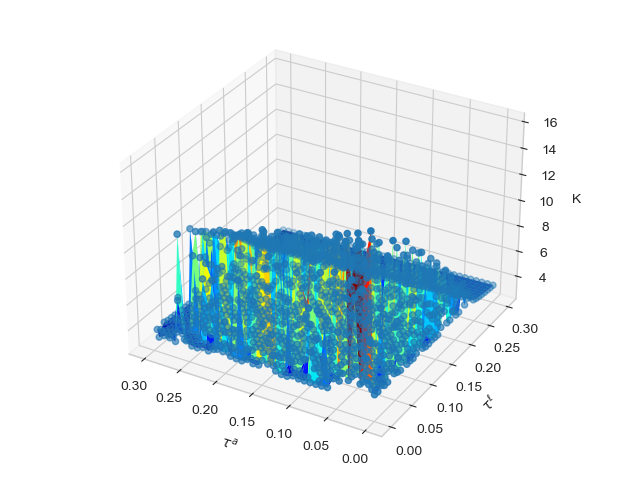

In [68]:
plot_over_taugrid(model_dict_zoom,'K',zname='K')

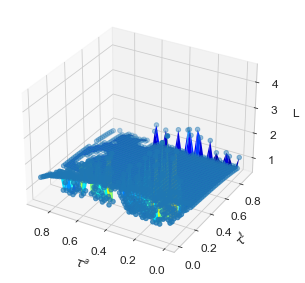

In [43]:
plot_over_taugrid(model_dict,'L',zname='L')

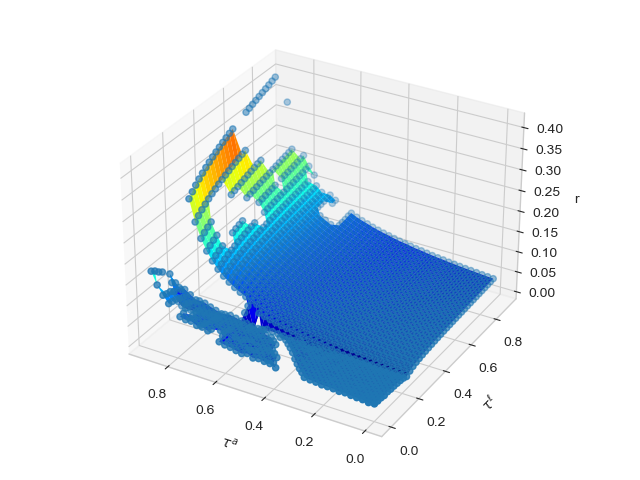

In [7]:
plot_over_taugrid(model_dict,'r',zname='r')

In [9]:
np.nanmin(model_dict['r'])

0.010886866708162385

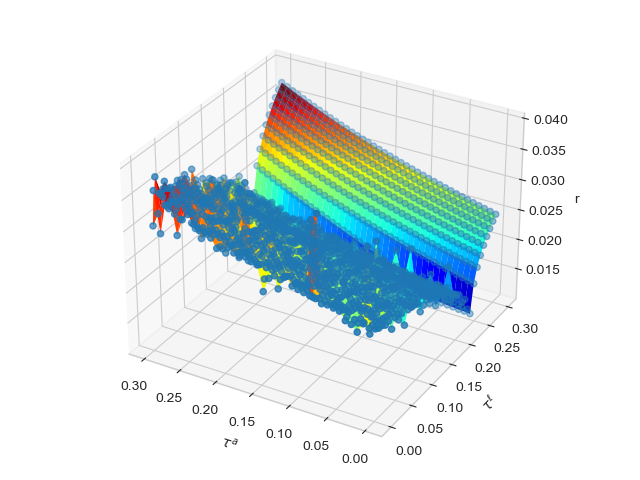

In [67]:
plot_over_taugrid(model_dict_zoom,'r',zname='r')

In [17]:
%matplotlib inline